# ML Prediction of Refraction Error under a given Lens in Cataract Surgery 

This is a minimal vial model. It predicts the the refraction error under a given IOL lens type and power.

$[Optical Biometry] + [Patien Data] + [Lens Type] + [Lens Power] + [AConstants] = [Refraction Error]$

We could also control for the aimed refraction error, but there is only data for half of the patients on that, and i think it would be more helpful, if the model predicts the absolute refraction error. The deviation could be then be part of a post-analysis.

For now, we ignore the relations to astigmatism.

## Import 

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score, ConfusionMatrixDisplay, f1_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, root_mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV

from lazypredict.Supervised import LazyRegressor

from sklearn import set_config
set_config(transform_output="pandas")

## Functions

In [9]:
# A function that returns several regression model performance metrics
def regression_perf(y_true, y_pred, model_name, save=False):
    # Create csv file, if it doesnt exist, else read it
    filename = 'data/model_performance_comparison_v2.csv'
    if not os.path.exists(filename):
        with open(filename, 'w'): pass
        performance_metrics = pd.DataFrame(columns=["model", "MAE", "MSQ", "MAPE", "R2", "RMSE"])
    else:
        performance_metrics = pd.read_csv(filename)

    if save==False:
        model_name = f"*not saved*"
  
    # make predictions on test and trained data
    mae = mean_absolute_error(y_true = y_true, y_pred = y_pred).round(1)
    sqe = mean_squared_error(y_true = y_true, y_pred = y_pred).round(1)
    ape = mean_absolute_percentage_error(y_true = y_true, y_pred = y_pred).round(3)
    r2s = r2_score(y_true = y_true, y_pred = y_pred).round(3)
    rmsle = root_mean_squared_error(y_true = y_true, y_pred = y_pred).round(1)

    # compile new data and add to df
    new_data = pd.DataFrame({"model": model_name, "MAE": mae, "MSQ": sqe, "MAPE": ape, "R2": r2s, "RMSE": rmsle}, index=[0])
    performance_metrics = pd.concat([performance_metrics, new_data], ignore_index=True)

    # save to csv
    if save==True:
        performance_metrics.to_csv(filename, index = False)

    return performance_metrics

## Prepare Dataset

In [44]:
# Load data
data = pd.read_csv("data/data_ML_mvm_v1.csv")
data

,lens_series,sphere,cyl,ax,se,IOL_torisch_dpt,IOL_dpt,AL,VKT,LD,...,R2_at,DeltaD_at,WZW,refr,A0,A1,A2,sex,age,proc_short
0,MBI SAL 302A,0.00,-0.75,NaN,-0.38,NaN,17.50,24.96,3.01,4.70,...,81.00,171.00,12.00,0.00,-0.70,0.12,0.22,2,60,Phako
1,Zeiss AT Torbi,0.25,-0.75,NaN,-0.12,1.00,21.00,23.06,2.97,4.64,...,87.00,177.00,12.10,0.30,1.13,0.40,0.10,2,74,Phako
2,Domilens 677,0.75,-1.00,NaN,0.25,NaN,21.00,23.29,2.60,5.15,...,171.00,NaN,11.90,0.02,0.19,0.19,0.17,2,85,Phako
3,Domilens 677,1.25,-1.50,NaN,0.50,NaN,22.50,23.70,3.12,4.67,...,95.50,175.00,12.65,-0.03,0.19,0.19,0.17,1,80,Phako
4,Domilens 677,0.62,-1.12,75.00,0.06,NaN,21.00,22.79,2.91,5.18,...,170.00,80.00,12.10,NaN,NaN,NaN,NaN,1,77,Phako
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5582,Domilens 677,0.50,-1.00,NaN,0.00,NaN,19.50,24.24,2.98,5.21,...,175.00,NaN,12.30,-0.01,0.19,0.19,0.17,1,86,Phako
5583,Bausch & Lomb Envista,0.25,-0.75,126.00,-0.12,NaN,21.50,23.38,3.07,4.60,...,111.00,NaN,12.20,0.11,0.18,0.32,0.17,2,72,Phako
5584,Bausch & Lomb Envista,0.50,-0.75,87.00,0.12,NaN,22.00,22.79,2.42,5.02,...,70.50,160.50,11.65,-0.31,0.18,0.32,0.17,1,66,FLACS
5585,Domilens 677,-1.00,-0.50,NaN,-1.25,NaN,22.50,22.93,2.99,4.91,...,151.00,NaN,11.80,-0.17,0.19,0.19,0.17,1,70,Phako


drop unneeded columns
- sphere and cyl, as they are within SE
- a constants. half of all cases missing and the information is already within the name of the lens
- ax, IOL_torisch_dpt and R2, as they are bound to toric information
- refr = expected refraction error, as this is not necessary for the predition
- add-on parameteres, like *_SD (Standad Deviation of each eye measurement) and *_at (angle of astigmatism measurement)
- proc_short (Phako vs Femto) - it should not influence the model

In [ ]:
# remove columns, as discussed below, due to collinearity

# test number of NAs for Delta_at and R1_at
data.DeltaD_at.isna().sum() # ~1200 NAs, compared to ~400 for R1_at -> remove DeltaD_at

# remove NA in outcome  (n=1)
data = data.dropna(subset=["se"])

In [13]:
# drop unneeded columns
data = data.drop(
    [
        "sphere",
        "cyl",
        "ax",
        "IOL_torisch_dpt",
        "DeltaD_at",
        "R2",
        "refr",
        "AL_SD",
        "VKT_SD",
        "LD_SD",
        "R1_at",
        "R2_at",
        "proc_short",
    ],
    axis=1,
)

# also drop a constants. There are half of all cases missing and the information is already within the name of the lens
data = data.drop(["A0", "A1", "A2"], axis=1)

# data = data.drop(["lens_series"], axis=1)
##data = data.dropna(subset=["A0"])

# remove non-toric rows? just to try it
#data = data.loc[data["IOL_torisch_dpt"].isna()]

# try with aimed refraction error as feature and remove missing rows (~2400)
#data = data.loc[~data["refr"].isna()] 

Try further improving the models performance by reducing the number of features. As a quick-and-dirty approach I will limit the number of included lens types by reducing it to the most common ones - this way, one-hot-encoding will produce less features. 

In [14]:
# find most common lens types
lens_types_count = data["lens_series"].value_counts().reset_index()
lens_types_included = lens_types_count.loc[lens_types_count["count"] >= 18, "lens_series"]

# remove cases in dataset with othr lens types - remove ~100 rows
data = data.loc[data["lens_series"].isin(lens_types_included)]

In [16]:
# Quick correction of decimal insertion errors in LD

def change_decimal(x, cutoff):
    if x>cutoff:
        x = str(x).replace(".","")
        x = x[1]+"."+x[1:]
        x= float(x)
    return x

data["LD"] = data["LD"].apply(change_decimal, args={10:"cutoff"})

In [17]:
data

,lens_series,se,IOL_dpt,AL,VKT,LD,R,R1,DeltaD,WZW,sex,age
0,MBI SAL 302A,-0.38,17.50,24.96,3.01,4.70,7.91,7.93,0.21,12.00,2,60
1,Zeiss AT Torbi,-0.12,21.00,23.06,2.97,4.64,7.64,7.76,1.35,12.10,2,74
2,Domilens 677,0.25,21.00,23.29,2.60,5.15,7.68,7.73,0.51,11.90,2,85
3,Domilens 677,0.50,22.50,23.70,3.12,4.67,7.92,7.99,0.82,12.65,1,80
4,Domilens 677,0.06,21.00,22.79,2.91,5.18,7.51,7.54,0.36,12.10,1,77
...,...,...,...,...,...,...,...,...,...,...,...,...
5582,Domilens 677,0.00,19.50,24.24,2.98,5.21,7.89,7.95,0.69,12.30,1,86
5583,Bausch & Lomb Envista,-0.12,21.50,23.38,3.07,4.60,7.69,7.78,0.99,12.20,2,72
5584,Bausch & Lomb Envista,0.12,22.00,22.79,2.42,5.02,7.48,7.55,0.94,11.65,1,66
5585,Domilens 677,-1.25,22.50,22.93,2.99,4.91,7.65,7.68,0.33,11.80,1,70


## Split Dataset

Split Dataset in Test, Train and Validation Datasets

In [18]:
# Define y and X and shuffle dataset 
X = data.sample(frac=1, random_state=123).reset_index(drop=True)
y = X.pop("se")

# Split data for reserved validation set (some use the names "test" and "validation" the other way around)
X_, X_val, y_, y_val = train_test_split(X, y, test_size=0.17, random_state=123)

# Split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.22, random_state=123)

## Dummy Model

A very simplified model - adapted lean lens formula or Vergenzformel. Its made for calculation the IOL power, but I turn it so it calacualted the refraction

Original Lean Leans formula:

$IOL = (n/ (AL-D)) - K$

Adapted Formula:

$R = K + IOL - (n/ (AL-D))$


- $n$ = 1335        ... assumed refraction index at vitreus body (Glaskörperbrechnungsindex), is assumed here
- $AL$              ... Axial length (AL), taken from biometry (Achslänge)
- $D$ = 3           ... effective lens position (ELP), assumed at between 3 and 4 or 1.5?!?
- $K$ = 43          ... corneal refractrion power, measured by ceratometry - not measures by biometry, assumed here, as it is usually between 20 and 44 dpt



In [19]:
# a very simplified model - the lean lens formula or Vergenzformel
def lean_lens_formula(AL, IOL):
    n = 1335
    D = 3
    K = 43

    # Lean Lens Formula
    #IOL = (n/ (AL-D)) - K

    # Adapted Lean Lens Formula
    R = K + IOL - (n/ (AL-D))

    return R

In [20]:
# predict IOL based on Lean Lens Model
#dummy_y_pred_train = lean_lens_formula(X_train.OverallQual, y_train)
dummy_y_pred_test = lean_lens_formula(X_test.AL, X_test.IOL_dpt)

# use dummy prediction to compute performance parameters
regression_perf(y_test, dummy_y_pred_test, "dummy", save=False)

,model,MAE,MSQ,MAPE,R2,RMSE
0,dummy,2.20,8.30,651170209934094.50,-21.40,2.90
1,basic,0.40,0.30,43581603156144.59,0.19,0.60
2,RandForest#PCA,0.40,0.30,72082925923328.42,0.27,0.60
3,*not saved*,2.10,7.60,573221760721347.25,-16.68,2.80


A high R2 or low other parameter would be a good performance. The dummies performance is not good - but good enough for a dumb dummy.

## Feature Selection and Engineering

there are several ways to test and select features that are e.g., non-influential (low or no variance) or colinear (highly correlated features) and can distort the model. 

I will play around with different approaches and print the model comparison in the csv in the next section.   

### Collinarity
Corrlation matrix and heatmap to find highly correlated features 

In [21]:
corr = X.select_dtypes(np.number).corr()
corr_values = corr.unstack()
corr_values = corr_values.loc[corr_values!=1]
corr_values.sort_values(ascending=False).head(20)

VKT      AL        0.52
AL       VKT       0.52
R        WZW       0.49
WZW      R         0.49
AL       R         0.41
R        AL        0.41
WZW      AL        0.39
AL       WZW       0.39
VKT      WZW       0.37
WZW      VKT       0.37
age      LD        0.34
LD       age       0.34
R1       R         0.28
R        R1        0.28
LD       IOL_dpt   0.19
IOL_dpt  LD        0.19
R1       AL        0.14
AL       R1        0.14
WZW      R1        0.14
R1       WZW       0.14
dtype: float64

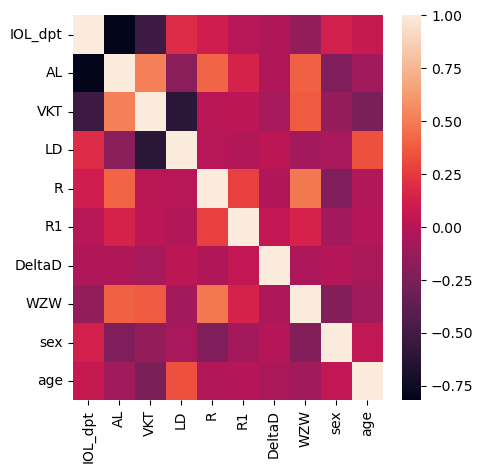

In [22]:
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(X.select_dtypes(np.number).corr());

There are some highly correlated features. Those are probably not needed anyway, so it makes sense, to remove those.
- SE and cyl: SE is the spheric equivalent - either take this or cyl and sphere, where SE is computes from. rather go without SE, to have more data
- DeltaD_at and R1_at: there is logical relationshsip between those parameters. Remove the one having more NAs
- R2 and R: same here, remove the one with more NAs. If the same, keep R (main parameter)
- IOL_torisch_dpt and DeltaD: DeltaD is a preoperative parameter, probably reflacting cylindric refraction deviations and predicting the toric lens. IOL_torishc_dpt on the other hand is taken from the implanted lens, so is more of an outcome parameter. Thus, remove IOL_torisch_dpt

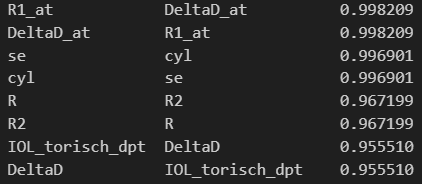

In [23]:
# data, as it goes into the model
data

,lens_series,se,IOL_dpt,AL,VKT,LD,R,R1,DeltaD,WZW,sex,age
0,MBI SAL 302A,-0.38,17.50,24.96,3.01,4.70,7.91,7.93,0.21,12.00,2,60
1,Zeiss AT Torbi,-0.12,21.00,23.06,2.97,4.64,7.64,7.76,1.35,12.10,2,74
2,Domilens 677,0.25,21.00,23.29,2.60,5.15,7.68,7.73,0.51,11.90,2,85
3,Domilens 677,0.50,22.50,23.70,3.12,4.67,7.92,7.99,0.82,12.65,1,80
4,Domilens 677,0.06,21.00,22.79,2.91,5.18,7.51,7.54,0.36,12.10,1,77
...,...,...,...,...,...,...,...,...,...,...,...,...
5582,Domilens 677,0.00,19.50,24.24,2.98,5.21,7.89,7.95,0.69,12.30,1,86
5583,Bausch & Lomb Envista,-0.12,21.50,23.38,3.07,4.60,7.69,7.78,0.99,12.20,2,72
5584,Bausch & Lomb Envista,0.12,22.00,22.79,2.42,5.02,7.48,7.55,0.94,11.65,1,66
5585,Domilens 677,-1.25,22.50,22.93,2.99,4.91,7.65,7.68,0.33,11.80,1,70


## Model Run

In [24]:
# Define features by dtype
X_num_columns = X.select_dtypes(include="number").columns
X_cat_columns = X.select_dtypes(include="object").columns

In [25]:
# create numerical pipeline
numeric_pipe = make_pipeline(
    SimpleImputer(strategy="mean"),
)

 # create categorical pipeline, with SimpleImputer and OneHotEncoder
categoric_hot_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="N_A"),
    OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist',min_frequency=0.03)
)

# Build preprocessor
preprocessor = make_column_transformer(
    (numeric_pipe, X_num_columns),
    (categoric_hot_pipe, X_cat_columns)
)


# Create Full Pipeline with ML model 
full_pipeline = make_pipeline(  preprocessor,
                                PCA(),
                                StandardScaler(),
                                GradientBoostingRegressor()                                
                                # RFECV(RandomForestRegressor(), n_jobs=-2, cv=None)
                                # RandomForestRegressor()
                                )

full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['IOL_dpt', 'AL', 'VKT', 'LD', 'R', 'R1', 'DeltaD', 'WZW', 'sex', 'age'], dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='N_A',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 min_frequency=0.03,
                                                                                 sparse_output=False))]),
                                                  Index(['lens_series'], dtype='object'))])),
                ('pca', PCA()), ('standardscaler', StandardScaler()),
                ('gradientboostingregressor', GradientBoostingRegressor())])

In [26]:
# show important features
step_correction = 2
pd.DataFrame(
    {
        "feature": full_pipeline[0+step_correction].get_feature_names_out(),
        "importance": full_pipeline[1+step_correction].feature_importances_,
    }
).sort_values("importance", ascending=False)

,feature,importance
5,pca5,0.20
9,pca9,0.17
13,pca13,0.15
7,pca7,0.09
1,pca1,0.08
2,pca2,0.06
10,pca10,0.06
11,pca11,0.05
3,pca3,0.04
12,pca12,0.03


In [27]:
# define parameter grid
param_grid = {
    'standardscaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    #"standardscaler__with_mean":[True, False],                   
    #"standardscaler__with_std":[True, False],
    "columntransformer__pipeline-1__simpleimputer__strategy":["mean", "median"],                  
    "columntransformer__pipeline-2__onehotencoder__min_frequency": np.arange(0.01, 0.11, 0.02),
    #"columntransformer__pipeline-1__columntransformer-1__nothing__kw_args": [{'r': r} for r in np.arange(0.1, 1.1, 0.2)],


    # 'randomforestregressor__n_estimators': [100, 200, 300],  # Number of trees in the forest
    # 'randomforestregressor__max_depth': [None, 10, 20, 30],  # Maximum number of levels in each decision tree
    # 'randomforestregressor__min_samples_split': [2, 5, 10],  # Minimum number of data points placed in a node before the node is split
    # 'randomforestregressor__min_samples_leaf': [1, 2, 4],  # Minimum number of data points allowed in a leaf node
    # 'randomforestregressor__max_features': [1, 'sqrt', 'log2'],  # Number of features to consider at every split

}

# define cross validation. RandomizedSearchCV is much faster. n_iter is additional to GridSearchCV and defines the nr of iterations (default=10) 
search = RandomizedSearchCV(        
                                    full_pipeline,
                                    param_grid,
                                    cv=5,                                       # the value for K in K-fold Cross Validation
                                    refit=True,                                 # Refit an estimator using the best found parameters on the whole dataset, (default = True)
                                    scoring='r2',                               # the performance metric to use (default = none)
                                    verbose=5,                                  # we want informative outputs during the training process 
                                    n_iter=500,                                 # nr of iterations, must be balanced between model complexity and computational power/time
                                    n_jobs=-2                                   # the number of processors we want to employ. 
                                    )

In [28]:
# Run parameter grid
search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer())]),
                                                                               Index(['IOL_dpt', 'AL', 'VKT', 'LD', 'R', 'R1', 'DeltaD', 'WZW', 'sex', 'age'], dtype='object')),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(fill_value='N_A',
                                                                                                              strategy='consta...
                                             ('gradientboostingregressor',
                                              GradientBoostingRegressor())]),
                   n_iter=500, n_jobs=-2,
                   param_distributions={'columntransformer__pipeline-1__simpleimputer__strategy': ['mean',
                                                                                                   'median'],
                                        'columntransformer__pipeline-2__onehotencoder__min_frequency': array([0.01, 0.03, 0.05, 0.07, 0.09]),
                                        'standardscaler': [StandardScaler(),
                                                           MinMaxScaler(),
                                                           RobustScaler()]},
                   scoring='r2', verbose=5)

In [29]:
# Show best parameters
search.best_params_

{'standardscaler': RobustScaler(),
 'columntransformer__pipeline-2__onehotencoder__min_frequency': 0.01,
 'columntransformer__pipeline-1__simpleimputer__strategy': 'median'}

## Model Performance
test the models performance and compare performance between models

In [30]:
# whats the predictons performance?
y_pred_train = full_pipeline.predict(X_train)
#y_pred_train = search.predict(X_train)
y_pred_test = full_pipeline.predict(X_test)
#y_pred_test = search.predict(X_test)

r2_train = r2_score(y_true = y_train, y_pred = y_pred_train).round(3)
r2_test = r2_score(y_true = y_test, y_pred = y_pred_test).round(3)

print("R2: \nTrain", r2_train, "\nTest ", r2_test)

R2: 
Train 0.477 
Test  0.287


In [31]:
# Display (and add) model performance parameters to csv list
regression_perf(y_test, y_pred_test, "GradBoost#PCA", save=False)

,model,MAE,MSQ,MAPE,R2,RMSE
0,dummy,2.20,8.30,651170209934094.50,-21.40,2.90
1,basic,0.40,0.30,43581603156144.59,0.19,0.60
2,RandForest#PCA,0.40,0.30,72082925923328.42,0.27,0.60
3,*not saved*,0.40,0.30,61204797435550.45,0.29,0.60


In [ ]:
# Compare original and predicted outcomes

# Function to round numeric value in 0.5 steps
def step_round(x, prec=2, base=.5):
    return round(base * round(float(x)/base),prec)

# compare results
compare_results = pd.DataFrame(
    {
        "Refr_real": y_test.reset_index(drop=True).round(2),
        "Refr_pred": pd.Series(y_pred_test).reset_index(drop=True).round(2),
        "Refr_real_r": y_test.reset_index(drop=True).apply(step_round),
        "Refr_pred_r": pd.Series(y_pred_test).reset_index(drop=True).apply(step_round)
    }
)
compare_results["diff"] = abs(compare_results.Refr_real-compare_results.Refr_pred).round(2)
compare_results["diff_r"] = abs(compare_results.Refr_real_r-compare_results.Refr_pred_r)


compare_results.sample(15)

,Refr_real,Refr_pred,Refr_real_r,Refr_pred_r,diff,diff_r
633,-1.62,-0.92,-1.50,-1.00,0.70,0.50
32,-0.50,-0.26,-0.50,-0.50,0.24,0.00
784,-0.06,-0.16,0.00,0.00,0.10,0.00
679,-0.42,-0.71,-0.50,-0.50,0.29,0.00
426,-1.38,-2.45,-1.50,-2.50,1.07,1.00
504,-0.44,-0.45,-0.50,-0.50,0.01,0.00
565,0.23,-0.13,0.00,0.00,0.36,0.00
917,-1.00,-0.51,-1.00,-0.50,0.49,0.50
33,-0.50,-0.25,-0.50,-0.50,0.25,0.00
536,0.00,-0.17,0.00,0.00,0.17,0.00


count   1003.00
mean       0.40
std        0.38
min        0.00
25%        0.14
50%        0.30
75%        0.55
max        3.39
Name: diff, dtype: float64

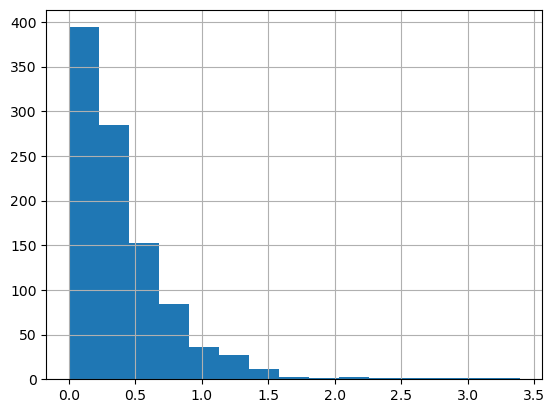

In [33]:
# Plot Difference between predicted and original outcome
compare_results["diff"].hist(bins=15)
compare_results["diff"].describe()

In [34]:
# some kind of quantification of performance. the less the better
compare_results["diff"].sum() / (compare_results["Refr_real"].count())

0.40122632103688927

Any patterns, for which extreme sides the prediction is worse?

In [ ]:
data_result = pd.concat([data, compare_results], axis=1)

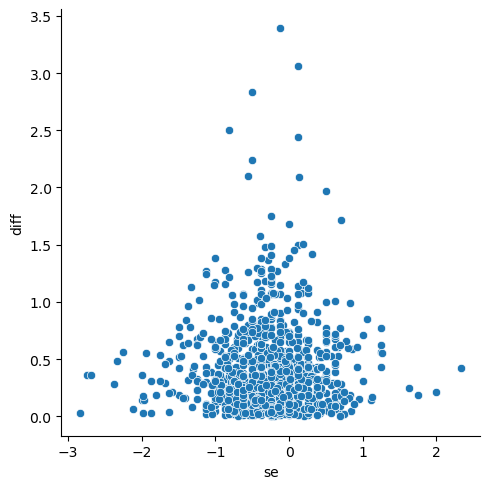

In [36]:
# Diff_Refraction over SE  - is the model underfitted for deviant SE (high or low)?  
sns.relplot(y=data_result["diff"], x=data_result["se"])

# visually, there is no pattern

## Model Finding

Use LazyPredicting to test 40 different estimators on the data.

It turns out, that the performance is maxing out around 0.27. 

In [37]:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

 21%|██▏       | 9/42 [00:01<00:05,  6.60it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 67%|██████▋   | 28/42 [00:04<00:02,  6.32it/s]

PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.


100%|██████████| 42/42 [00:06<00:00,  6.14it/s]


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1593
[LightGBM] [Info] Number of data points in the train set: 3555, number of used features: 11
[LightGBM] [Info] Start training from score -0.327603


In [38]:
predictions

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
SVR,0.26,0.27,0.56,0.42
NuSVR,0.26,0.27,0.56,0.37
LGBMRegressor,0.25,0.26,0.56,0.08
HistGradientBoostingRegressor,0.25,0.26,0.57,0.24
GradientBoostingRegressor,0.24,0.24,0.57,0.38
ExtraTreesRegressor,0.22,0.23,0.57,0.70
RandomForestRegressor,0.22,0.22,0.58,1.44
XGBRegressor,0.20,0.21,0.58,0.09
LassoCV,0.20,0.21,0.58,0.05


## Store Model

store the model in a pickle to use it e.g. on streamlit

In [39]:
# store the trained pipeline
import pickle
pickle.dump(full_pipeline,
            open(file='data/trained_pipe_v1.sav',
                 mode='wb'))

also store further information drom dataset into seperate tables

In [40]:
lens_types_in_v1 = data[["lens_series", "IOL_dpt"]].drop_duplicates()
lens_types_in_v1.to_csv("data/lens_types_in_v1.csv", index=False)

In [41]:
lens_types_in_v1.loc[lens_types_in_v1["lens_series"] == "Zeiss AT Torbi", ["IOL_dpt"]].median()

IOL_dpt   18.75
dtype: float64

In [42]:
lens_types_in_v1.loc[lens_types_in_v1["lens_series"] == "Zeiss AT Torbi", ["IOL_dpt"]]#.median()#.round(0)

,IOL_dpt
1,21.00
28,18.50
29,19.00
76,18.00
89,21.50
99,23.00
100,22.00
155,15.00
156,16.50
165,14.50
